# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [85]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

In [142]:
## Write a function that computes the squared loss & incorporates uncertainties on the measurements, dy

def chisq(x_i,y_i,a_i,b_i,dy):
    u = a_i*x_i + b_i ## This is your model
    chisq = (0.5*(y_i-u)**2)/(dy**2)  ## Chi-squared
    return chisq



,log_L,a,b
29,294.028216,0.0,355.102041
30,270.593346,0.0,367.346939
31,254.072270,0.0,379.591837
32,244.464990,0.0,391.836735
33,241.771504,0.0,404.081633
34,245.991812,0.0,416.326531
35,257.125916,0.0,428.571429
36,275.173814,0.0,440.816327


6.565656565656582 -650.0


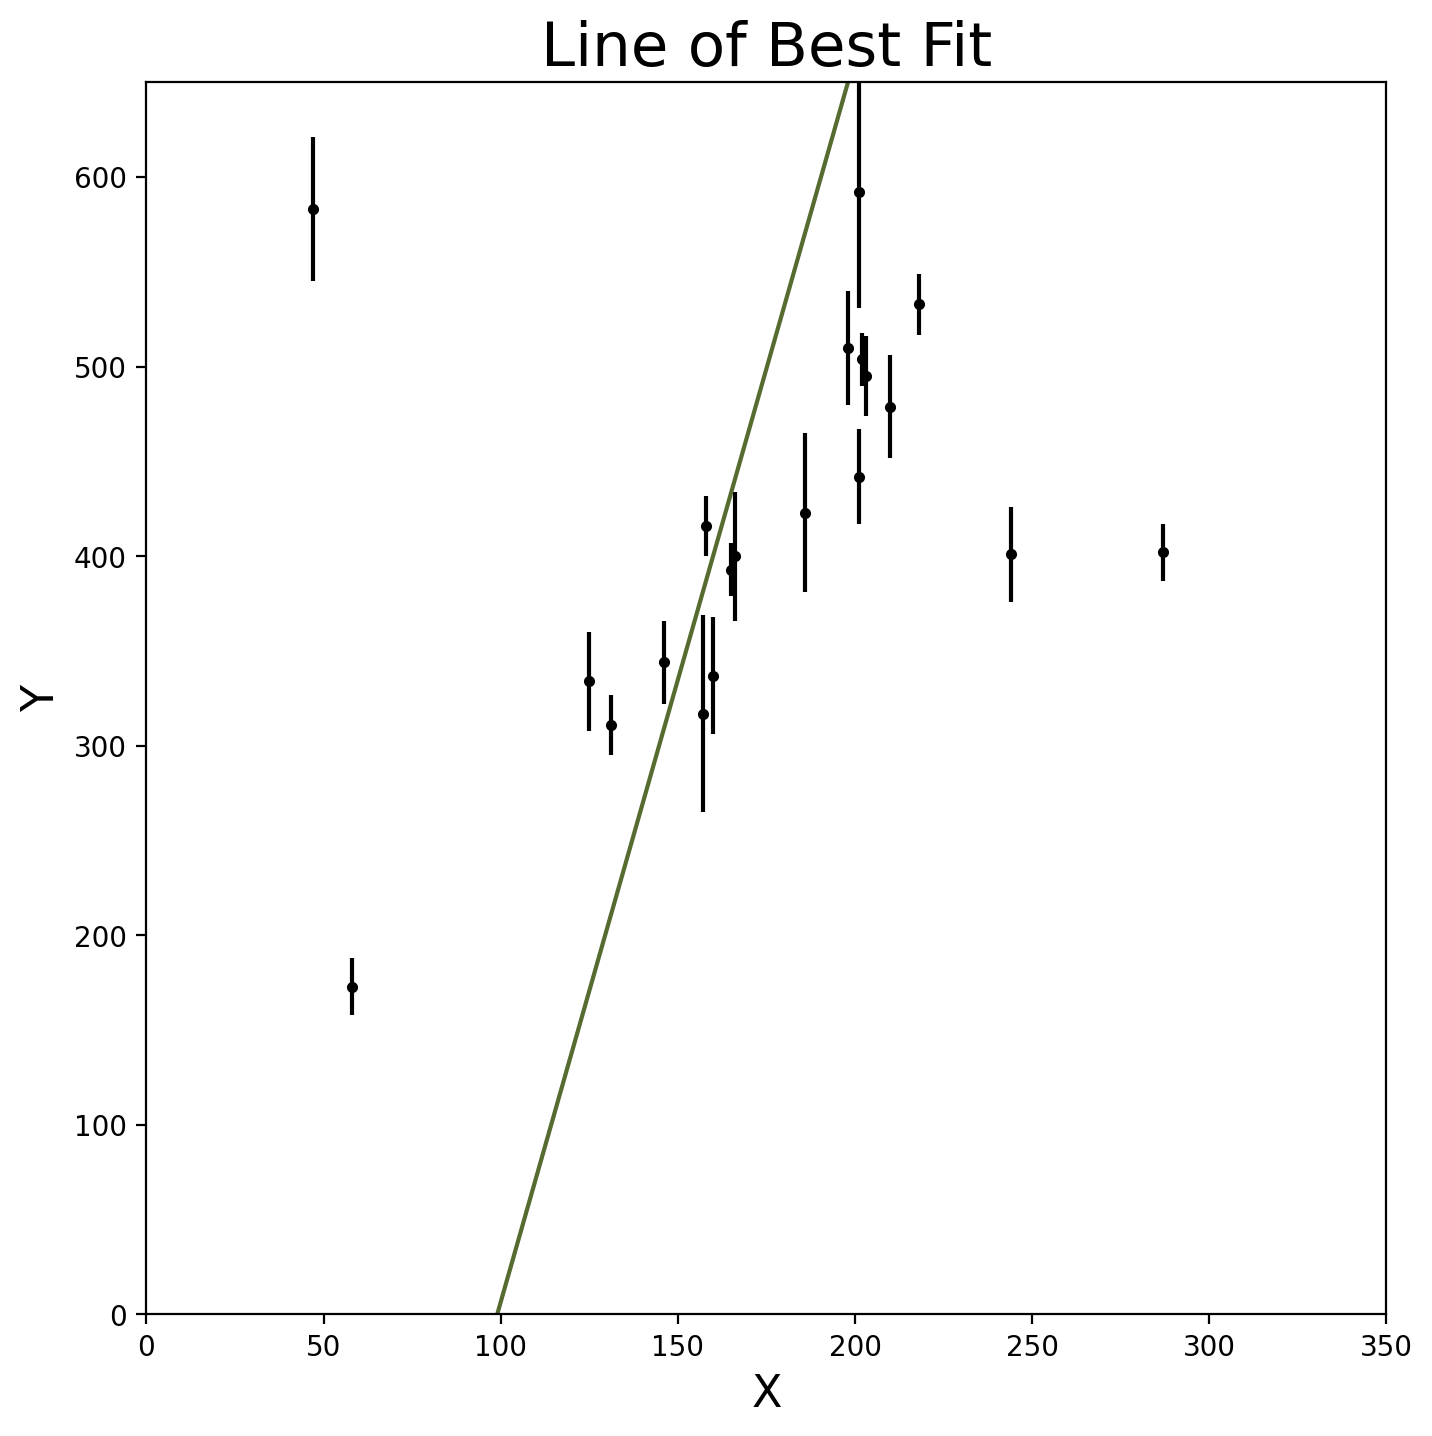

In [313]:
## Fit a line to the full sample by evaluating this likelihood on a grid of a, b

a_test = np.linspace(-650,650,100) 
b_test = np.linspace(-650,650,100) 

## Initialize 
log_L_list = []
a_list = []
b_list = []

plt.figure(figsize=(8,8))

## Minimize the summed chi-squared
for i in range(len(a_test)):
    for j in range(len(b_test)):
        log_L = np.sum(chisq(x,y,a_test[i],b_test[j],dy))
        log_L_list.append(log_L)
        a_list.append(a_test[i])
        b_list.append(b_test[j])
        #plt.plot(a_test[i],b_test[j],'.') # To test whether I am actually calculating on the right grid
        
## Pandas dataframe to keep my minimum chi-squared value tied to the correct a and b values
likelihood = pd.DataFrame({'log_L':log_L_list,'a':a_list,'b':b_list})

## Find parameters which minimize chi-squared
a_i = likelihood.a.iloc[likelihood.log_L.idxmin()]
b_i = likelihood.b.iloc[likelihood.log_L.idxmin()]

## Plot

plt.errorbar(x,y,yerr=dy,color='black',fmt='.')
plt.plot(a_test,a_i*a_test+b_i,color='darkolivegreen',label='Chi-Squared Minimization')

plt.xlim(0,350)
plt.ylim(0,650)

plt.xlabel('X',fontsize=16)
plt.ylabel('Y',fontsize=16)
plt.title('Line of Best Fit',fontsize=22)

print(a_i,b_i)

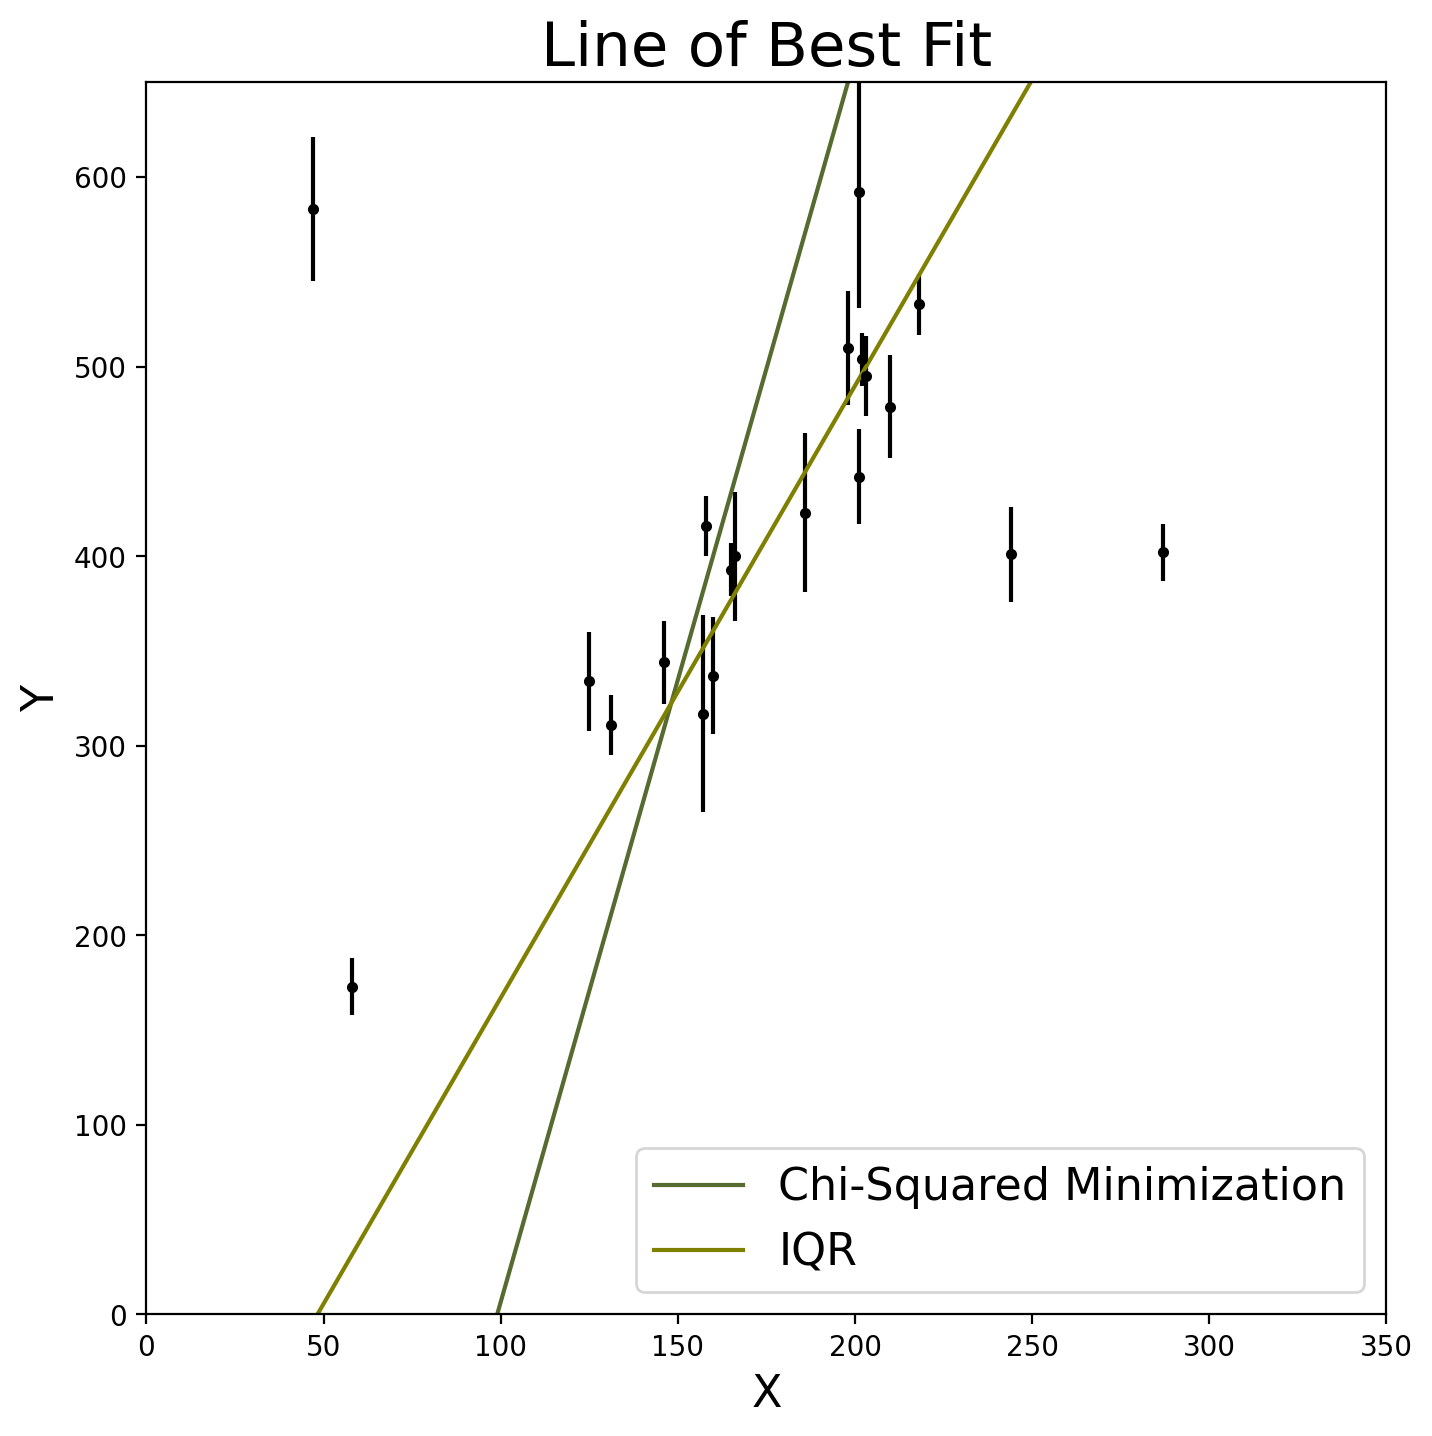

In [314]:
## Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected

## IQR:

x_25 = np.percentile(x,25)
x_75 = np.percentile(x,75)
y_25 = np.percentile(y,25)
y_75 = np.percentile(y,75)

## Plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,yerr=dy,color='black',fmt='.')
plt.plot(a_test,a_i*a_test+b_i,color='darkolivegreen',label='Chi-Squared Minimization')
plt.plot(a_test,((y_75-y_25)/(x_75-x_25))*(a_test-x_25)+y_25,color='olive',label='IQR')

plt.xlim(0,350)
plt.ylim(0,650)

plt.xlabel('X',fontsize=16)
plt.ylabel('Y',fontsize=16)
plt.title('Line of Best Fit',fontsize=22)
plt.legend(loc='lower right',fontsize=16)

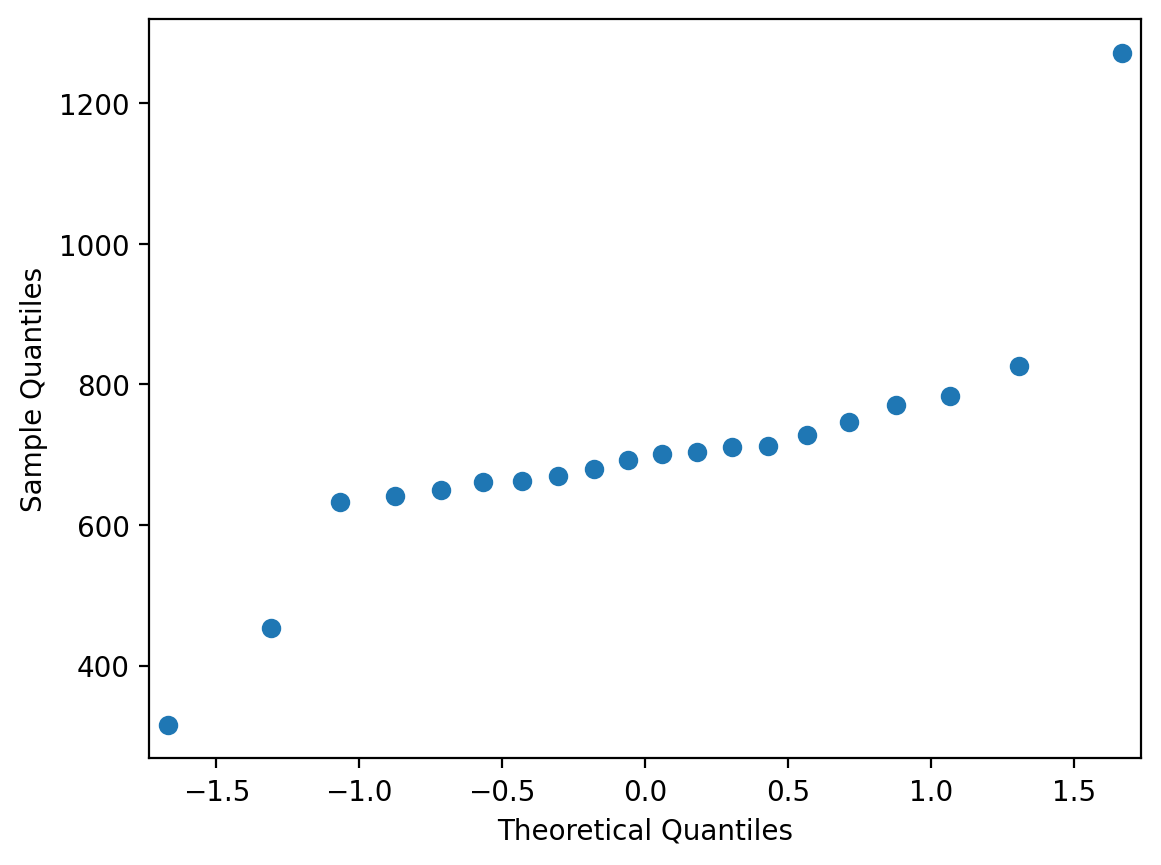

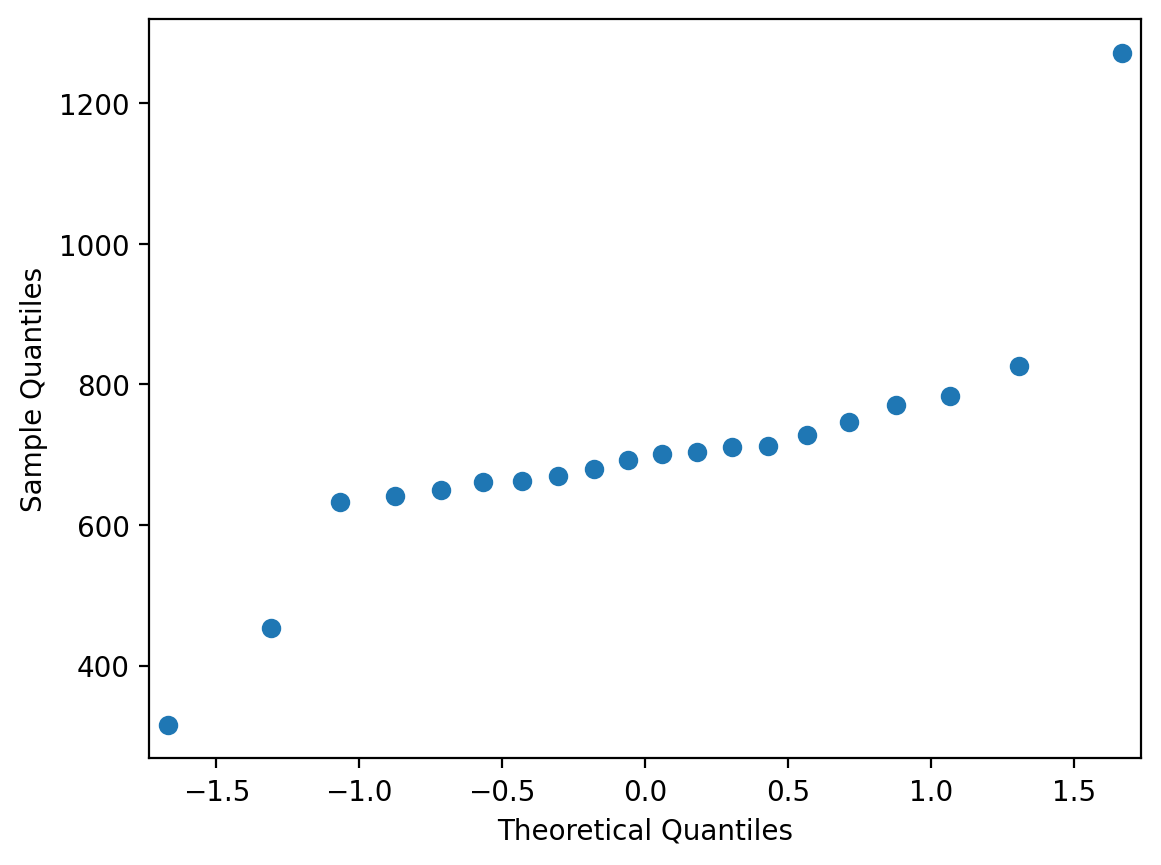

In [315]:
## And make a QQ plot of the residuals

import statsmodels.api as api
from scipy.stats import norm, uniform, cauchy

resid = y-((y_75-y_25)/(x_75-x_25))*(x-x_25)+y_25

api.qqplot(resid, norm, color='blue',label='Normal')

In [327]:
## Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties 𝑑𝑦

# Huber Loss
def huber(params):
    mu = (params[0]*x+params[1])
    u = (y-mu)**2/dy**2
    delta = 0.2
    huber_less =  0.5*u**2
    huber_more = delta*(np.abs(u)-0.5*delta)
    huber = np.where(np.abs(u)<=delta,huber_less,huber_more)
    return np.sum(huber)
   


Optimization terminated successfully.
         Current function value: 57.628674
         Iterations: 83
         Function evaluations: 159
[  1.07750885 212.7095682 ]


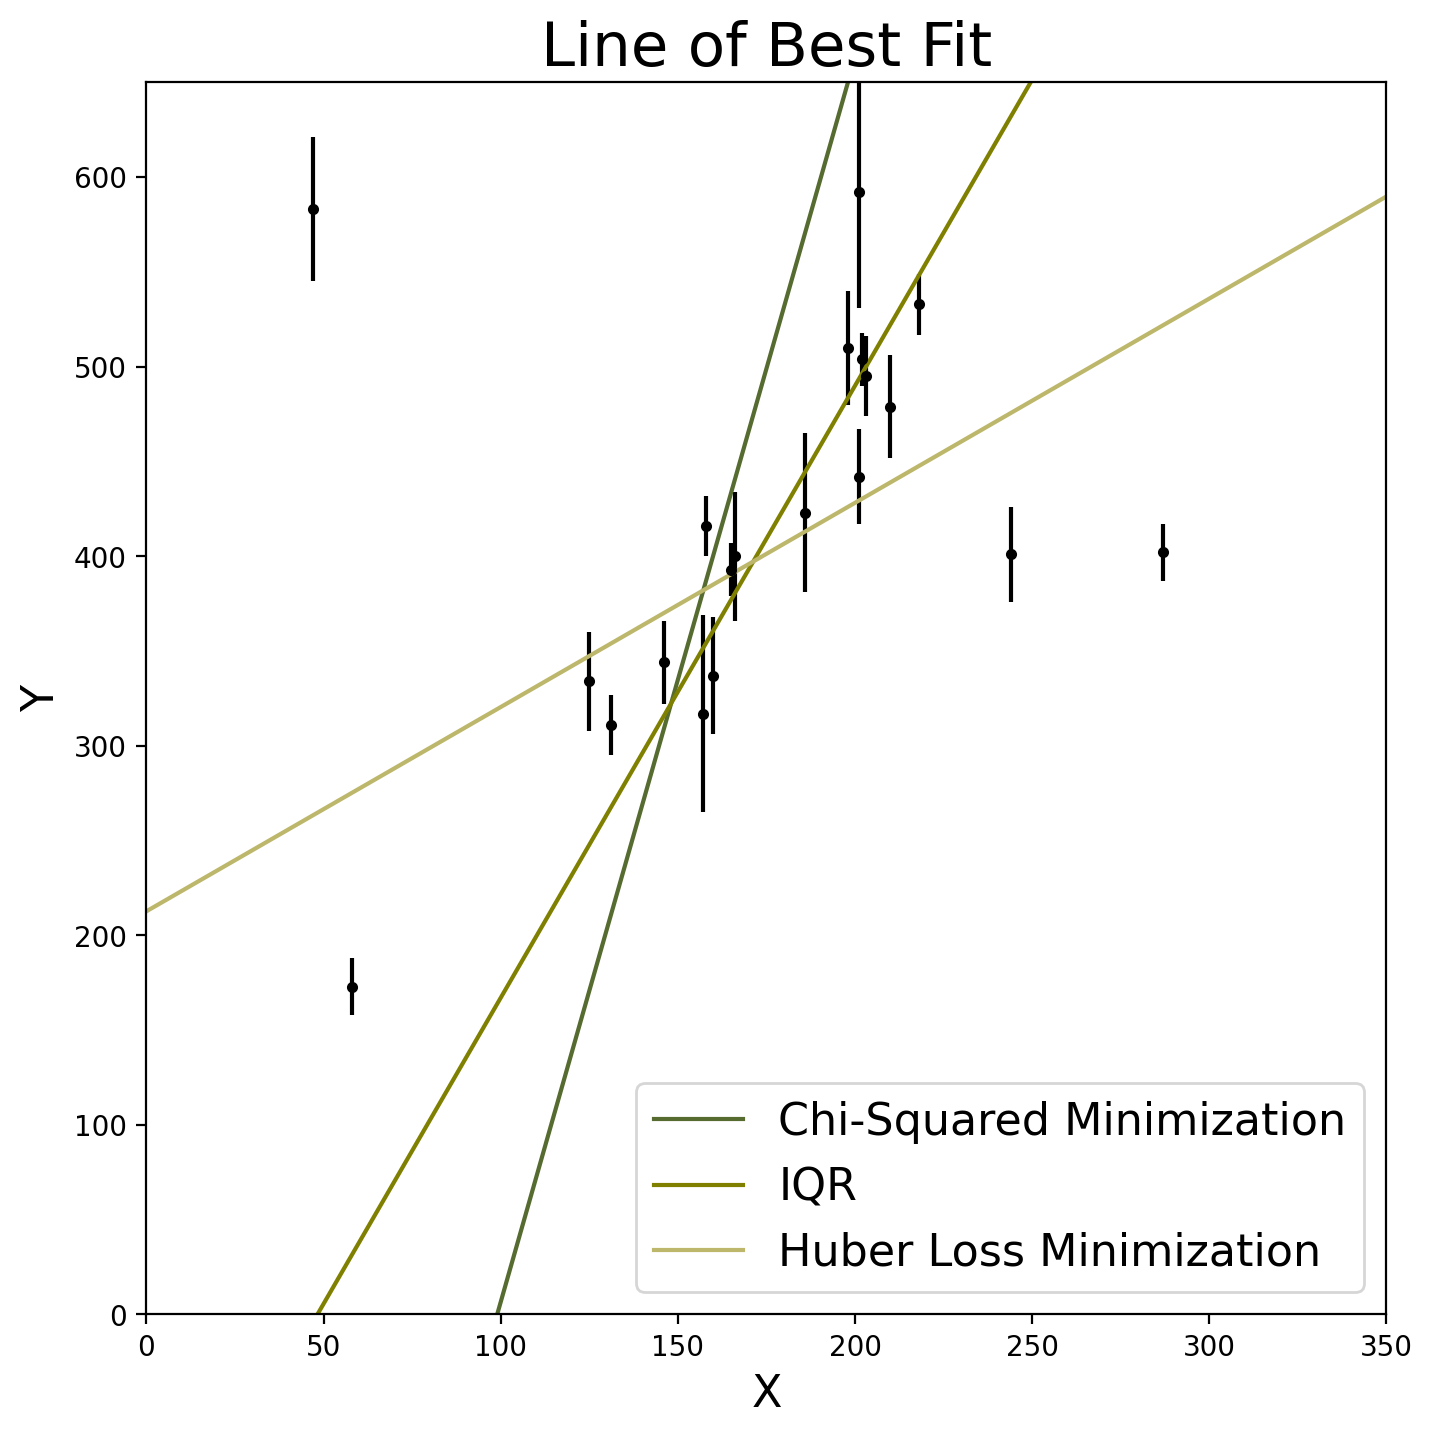

In [332]:
## Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod,
## except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals

from scipy.optimize import fmin

hubermin = fmin(huber,np.array([50,-100]))
print(hubermin)

## Plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,yerr=dy,color='black',fmt='.')
plt.plot(a_test,a_i*a_test+b_i,color='darkolivegreen',label='Chi-Squared Minimization')
plt.plot(a_test,((y_75-y_25)/(x_75-x_25))*(a_test-x_25)+y_25,color='olive',label='IQR')
plt.plot(a_test,hubermin[0]*a_test+hubermin[1],color='darkkhaki',label='Huber Loss Minimization')

plt.xlim(0,350)
plt.ylim(0,650)

plt.xlabel('X',fontsize=16)
plt.ylabel('Y',fontsize=16)
plt.title('Line of Best Fit',fontsize=22)
plt.legend(loc='lower right',fontsize=16)



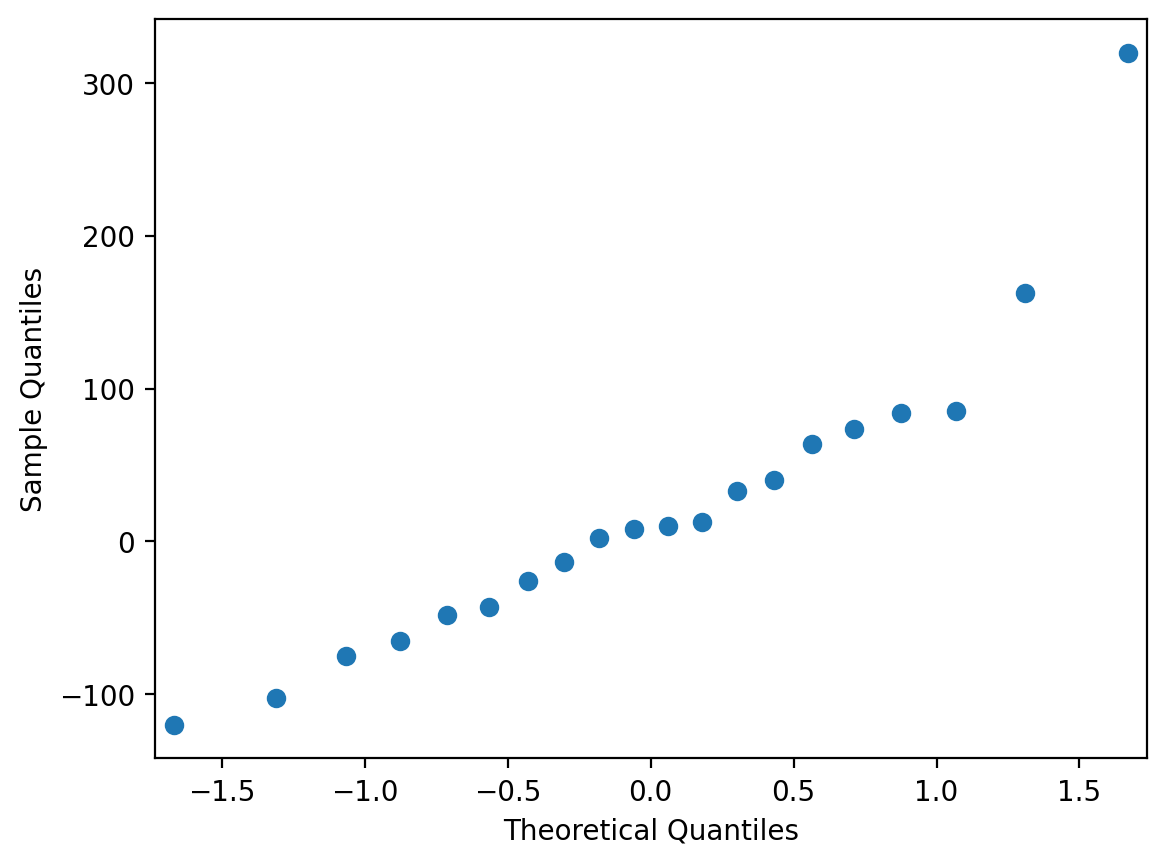

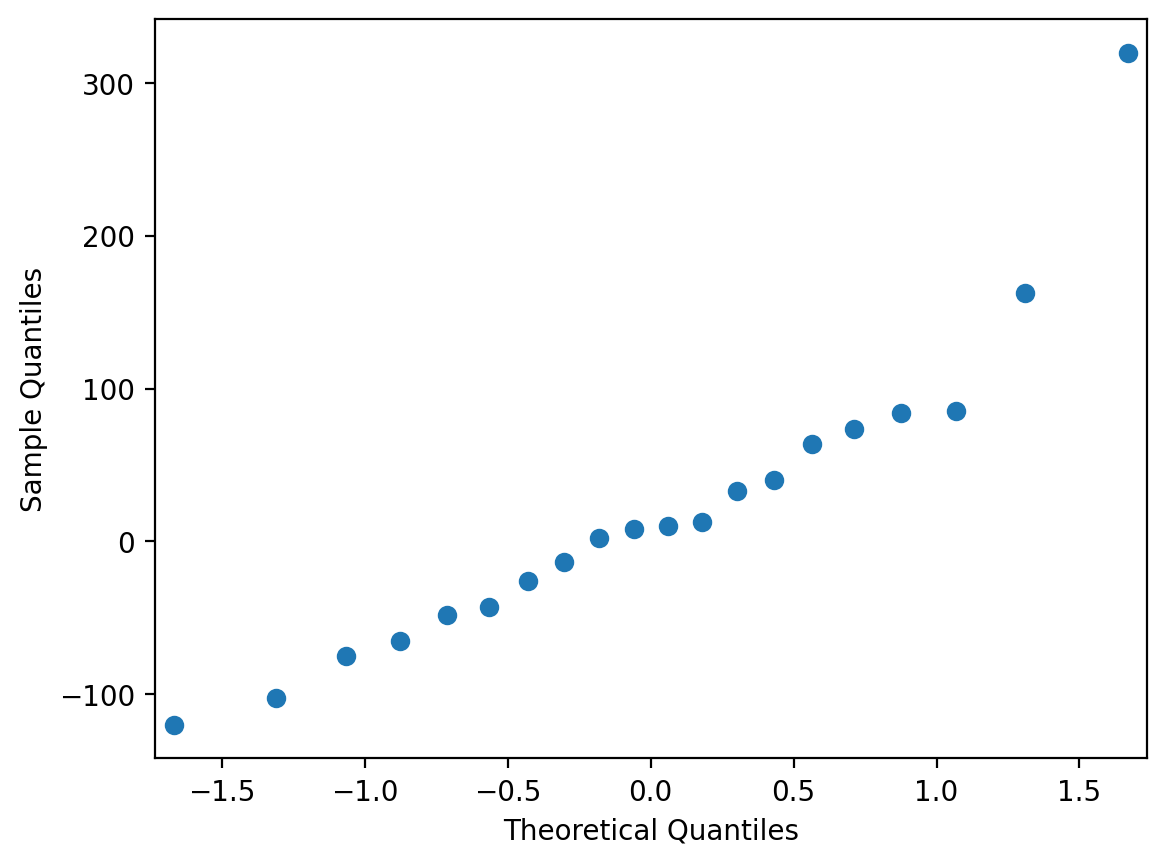

In [333]:
## QQ Plot of residuals
huber_resid = y-(hubermin[0]*x+hubermin[1])
api.qqplot(huber_resid, norm, color='blue',label='Normal')

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [7]:
## Packages
import pandas as pd

In [15]:
## Import data, slice by cloud and Cepheid mode
cepheids = pd.read_csv('Cepheids.csv')

lmc = cepheids[cepheids.Cloud=='LMC']
smc = cepheids[cepheids.Cloud=='SMC']

lmc_F = lmc[lmc.Mode=='F']
lmc_1 = lmc[lmc.Mode=='1']

smc_F = smc[smc.Mode=='F']
smc_1 = smc[smc.Mode=='1']

In [346]:
## More general huber function

def huber_loss(params,x,y):
    mu = params[0]*x+params[1]
    u = (y-mu)**2
    delta = 0.2
    huber_less =  0.5*u**2
    huber_more = delta*(np.abs(u)-0.5*delta)
    huber = np.where(np.abs(u)<=delta,huber_less,huber_more)
    return np.sum(huber)


## Get minimized slope and intercept

lmc_f_a, lmc_f_b = fmin(huber_loss,np.array([-3,16]),args=(lmc_F.logP1,lmc_F.W))
lmc_1_a, lmc_1_b = fmin(huber_loss,np.array([-3,16]),args=(lmc_1.logP1,lmc_1.W))
smc_f_a, smc_f_b = fmin(huber_loss,np.array([-3,16]),args=(smc_F.logP1,smc_F.W))
smc_1_a, smc_1_b = fmin(huber_loss,np.array([-3,16]),args=(smc_1.logP1,smc_1.W))

Optimization terminated successfully.
         Current function value: 4.119131
         Iterations: 38
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 3.321790
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 13.517019
         Iterations: 37
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 9.395321
         Iterations: 36
         Function evaluations: 69


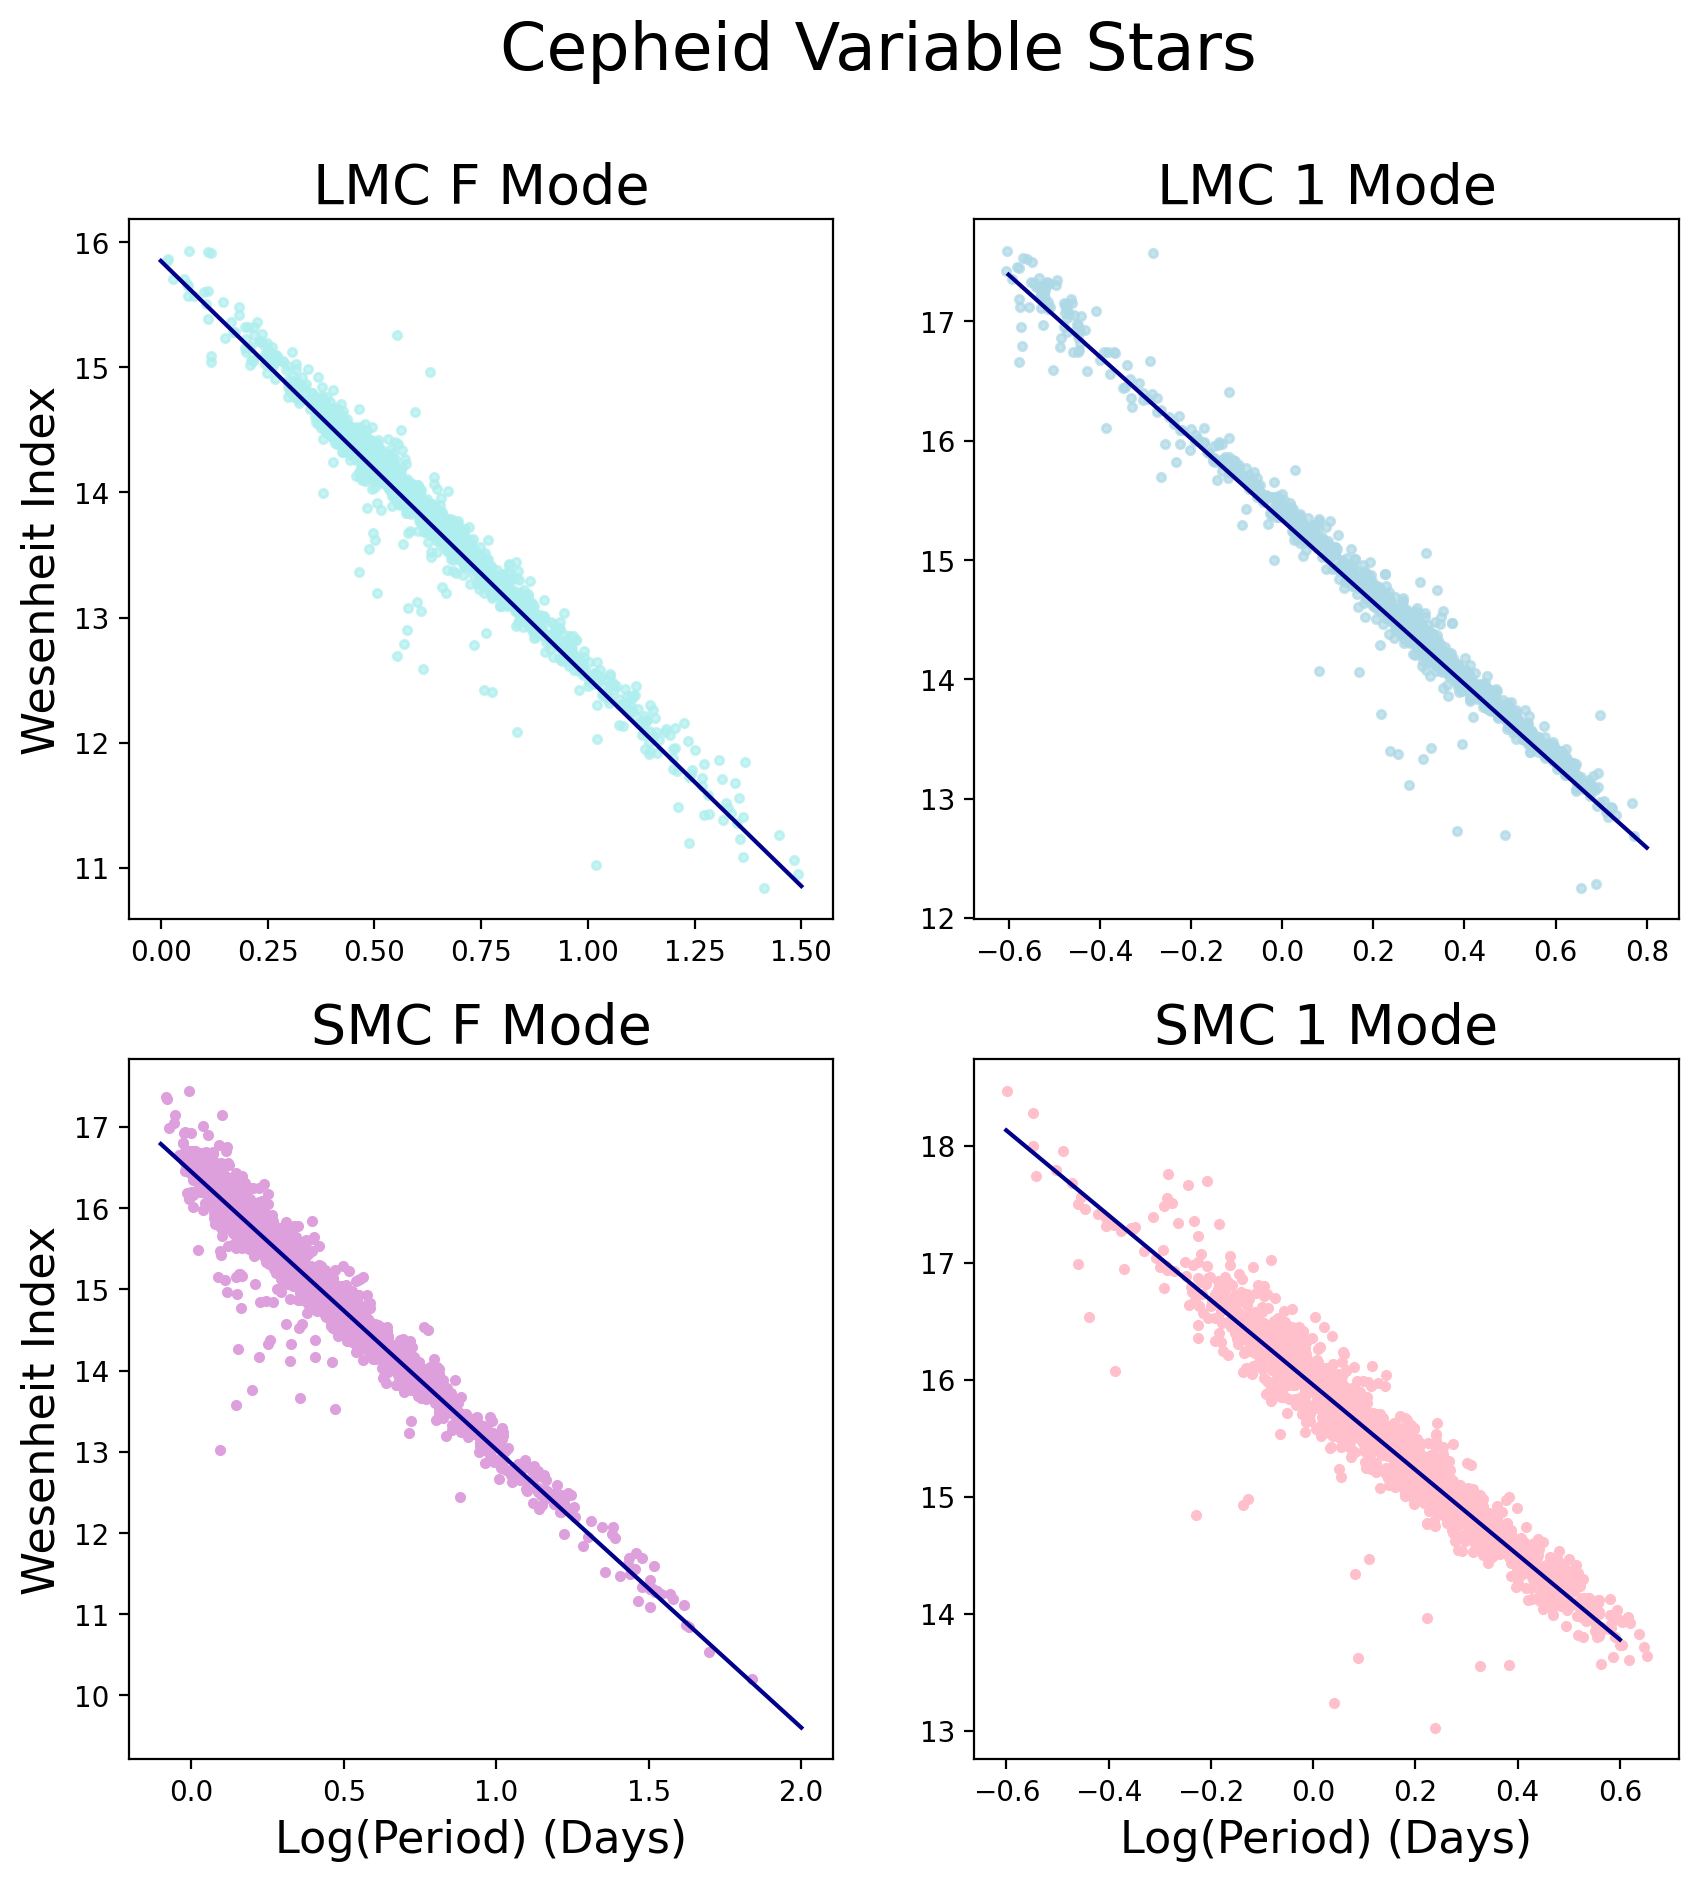

In [445]:
## Plot log(P1) vs. W with lines

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

fig.suptitle('Cepheid Variable Stars',fontsize=24)

ax0.set_title('LMC F Mode',fontsize=20)
ax0.set_ylabel('Wesenheit Index',fontsize=16)
ax0.plot(lmc_F.logP1,lmc_F.W,'.',color='paleturquoise',alpha=0.7)
ax0.plot(np.linspace(0,1.5,len(lmc_F.logP1)), lmc_f_a*np.linspace(0,1.5,len(lmc_F.logP1))+lmc_f_b,color='darkblue')

ax1.set_title('LMC 1 Mode',fontsize=20)
ax1.plot(lmc_1.logP1,lmc_1.W,'.',color='lightblue',alpha=0.7)
ax1.plot(np.linspace(-0.6,.8,len(lmc_1.logP1)), lmc_1_a*np.linspace(-0.6,.8,len(lmc_1.logP1))+lmc_1_b,color='darkblue')

ax2.set_title('SMC F Mode',fontsize=20)
ax2.set_xlabel('Log(Period) (Days)', fontsize=16)
ax2.set_ylabel('Wesenheit Index',fontsize=16)
ax2.plot(smc_F.logP1,smc_F.W,'.',color='plum')
ax2.plot(np.linspace(-0.1,2,len(smc_F.logP1)), smc_f_a*np.linspace(-0.1,2,len(smc_F.logP1))+smc_f_b,color='darkblue')

ax3.set_title('SMC 1 Mode',fontsize=20)
ax3.set_xlabel('Log(Period) (Days)', fontsize=16)
ax3.plot(smc_1.logP1,smc_1.W,'.',color='pink')
ax3.plot(np.linspace(-0.6,.6,len(smc_1.logP1)), smc_1_a*np.linspace(-0.6,.6,len(smc_1.logP1))+smc_1_b,color='darkblue');


#plt.tight_layout()

## Do I get bonus points for my pretty colors?

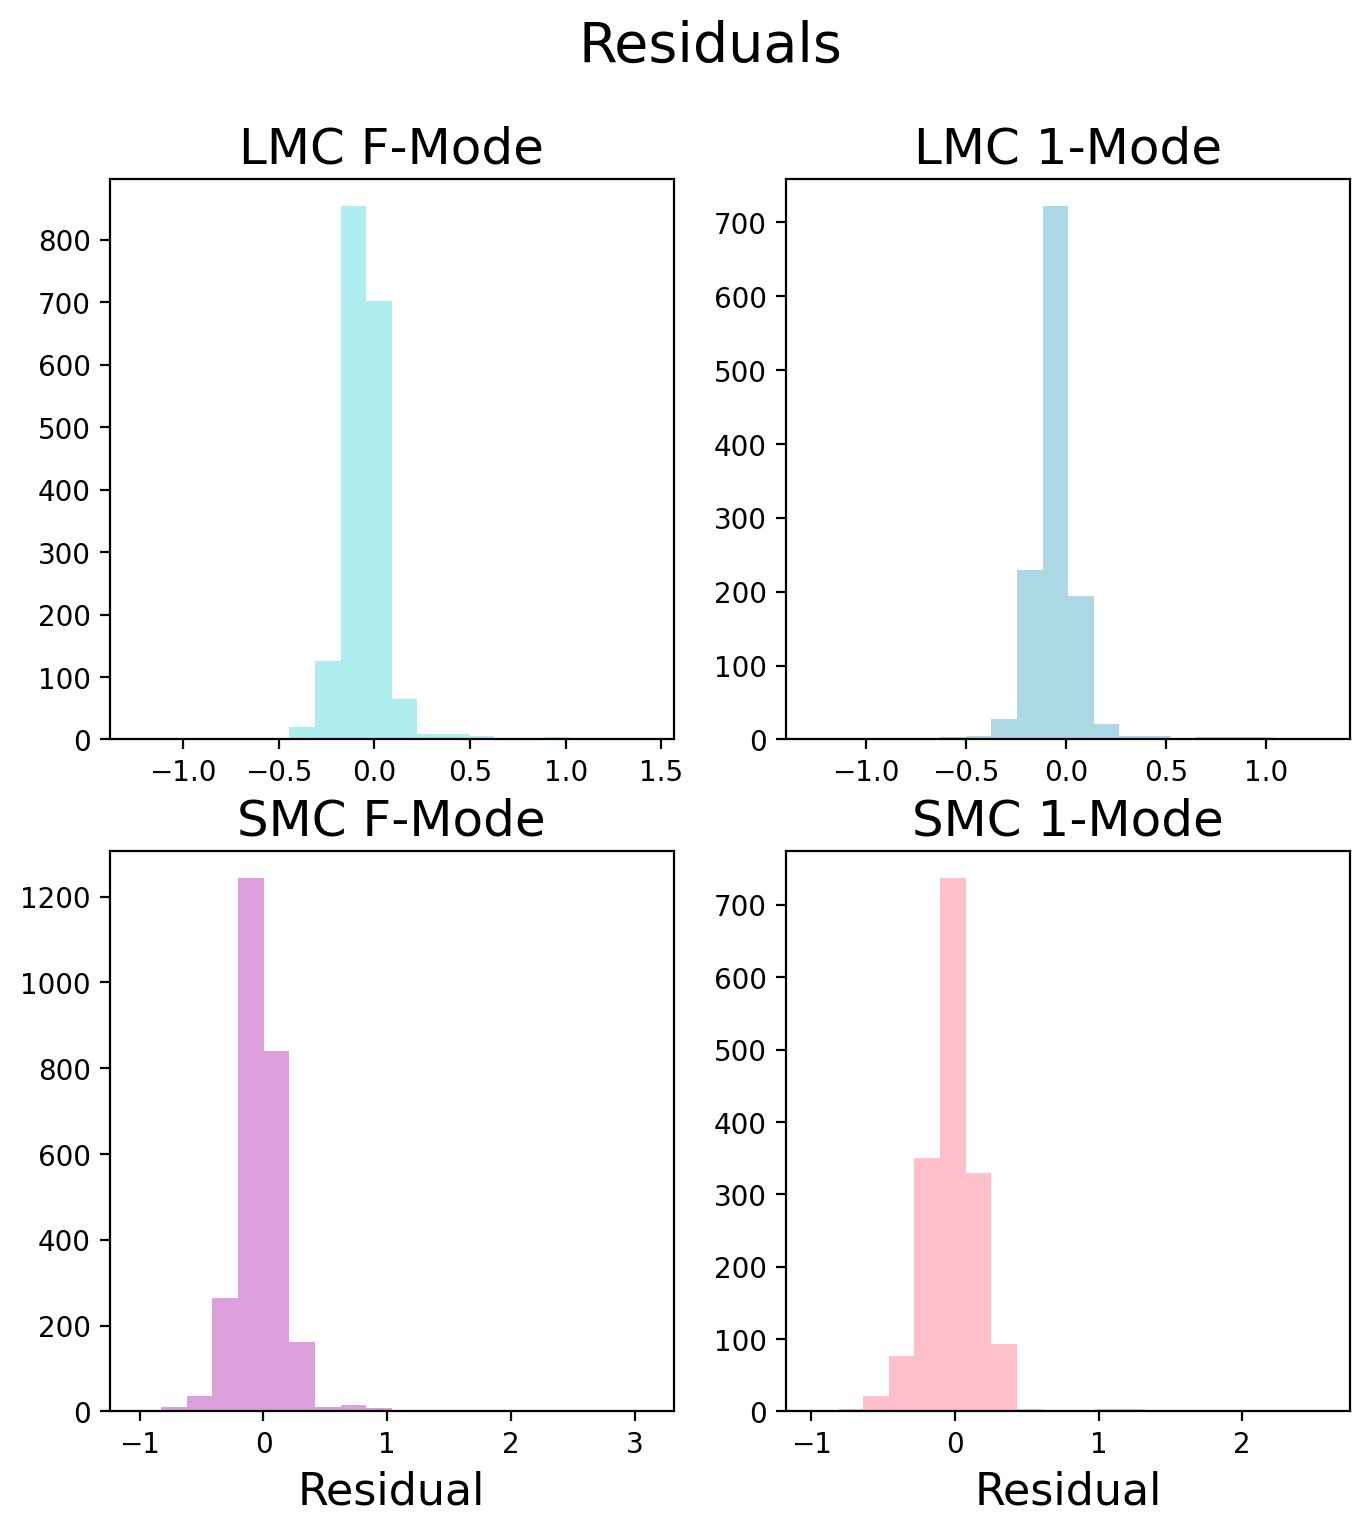

In [444]:
## Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why 

resid_lmc_f = lmc_f_a*lmc_F.logP1+lmc_f_b-lmc_F.W
resid_lmc_1 = lmc_1_a*lmc_1.logP1+lmc_1_b-lmc_1.W
resid_smc_f = smc_f_a*smc_F.logP1+smc_f_b-smc_F.W
resid_smc_1 = smc_1_a*smc_1.logP1+smc_1_b-smc_1.W


## Plot histograms of the sample

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2,figsize=(8,8))
fig.suptitle('Residuals',fontsize=20)

ax0.hist(resid_lmc_f,color='paleturquoise',bins=20)
ax0.set_title('LMC F-Mode',fontsize=18)
#ax0.set_xlabel('Residual',fontsize=16)

ax1.hist(resid_lmc_1,color='lightblue',bins=20)
ax1.set_title('LMC 1-Mode',fontsize=18)
#ax1.set_xlabel('Residual',fontsize=16)

ax2.hist(resid_smc_f,color='plum',bins=20)
ax2.set_title('SMC F-Mode',fontsize=18)
ax2.set_xlabel('Residual',fontsize=16)

ax3.hist(resid_smc_1,color='pink',bins=20)
ax3.set_title('SMC 1-Mode',fontsize=18)
ax3.set_xlabel('Residual',fontsize=16);

/home/meverri/anaconda3/envs/fds/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


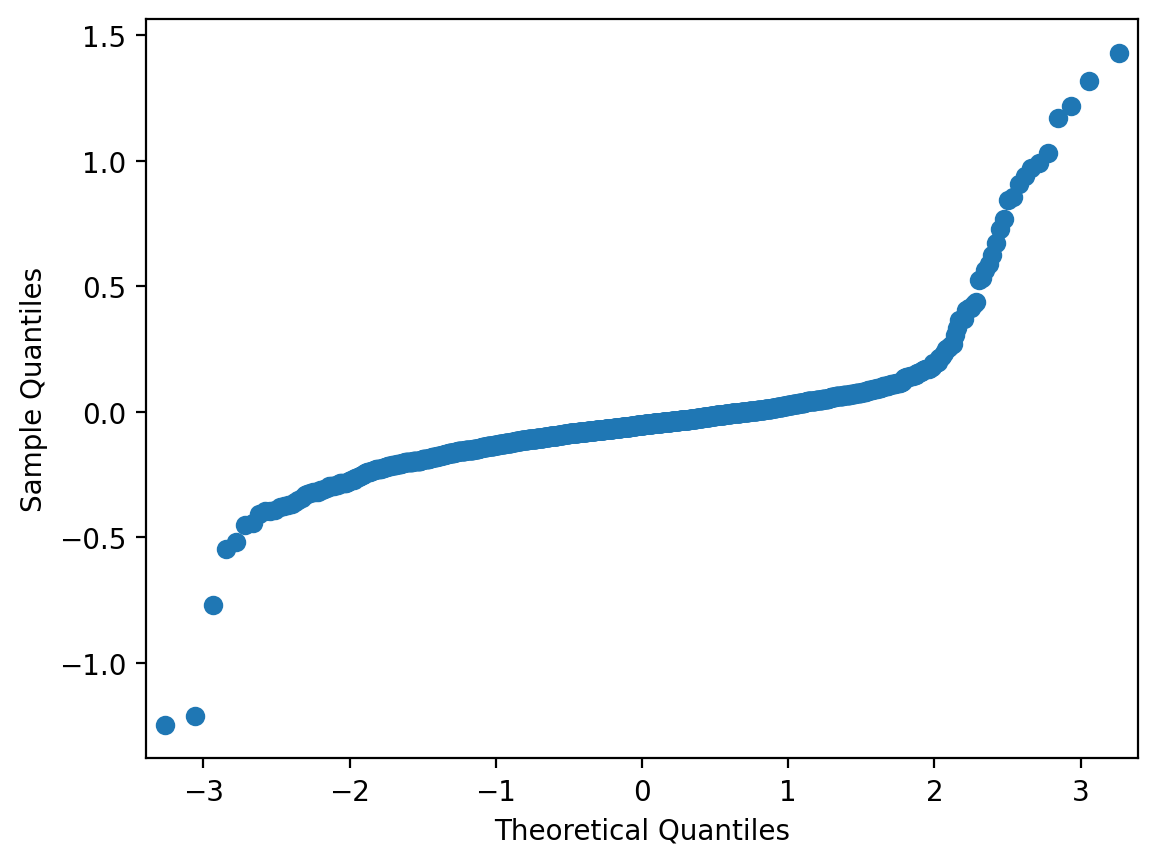

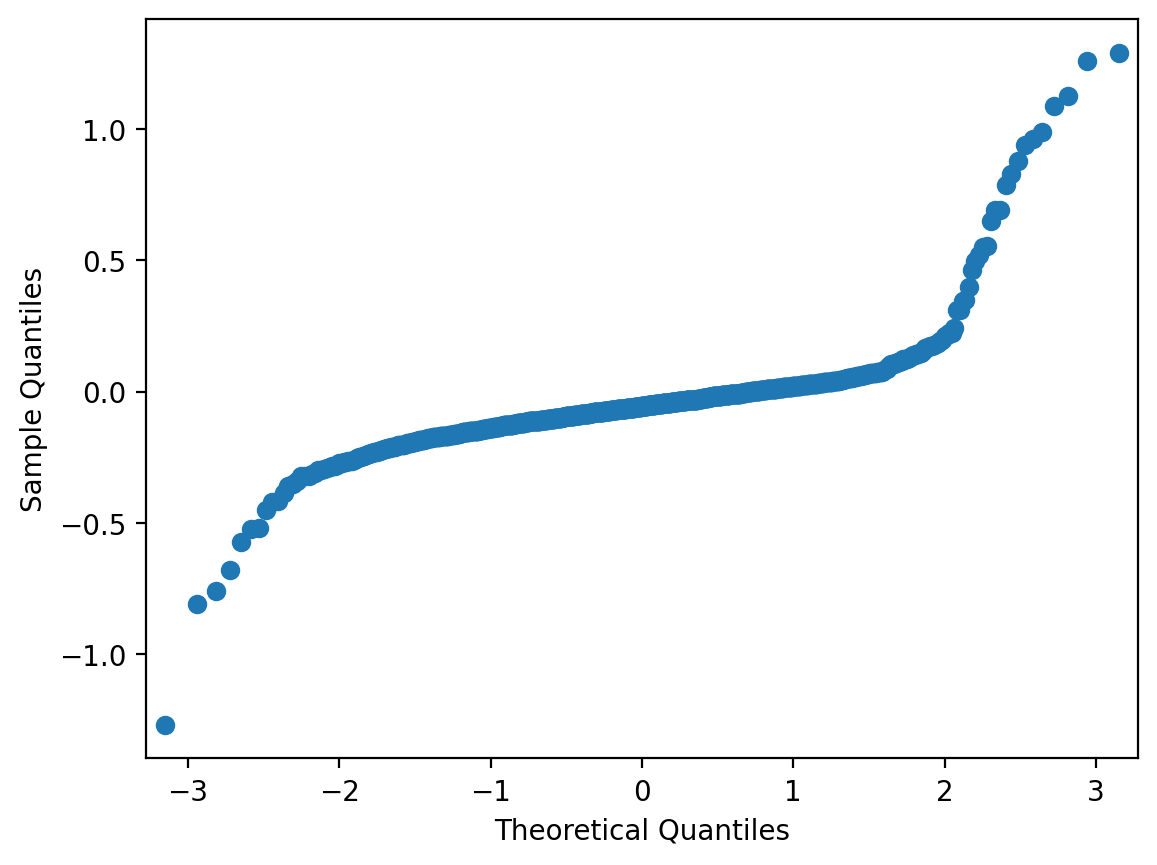

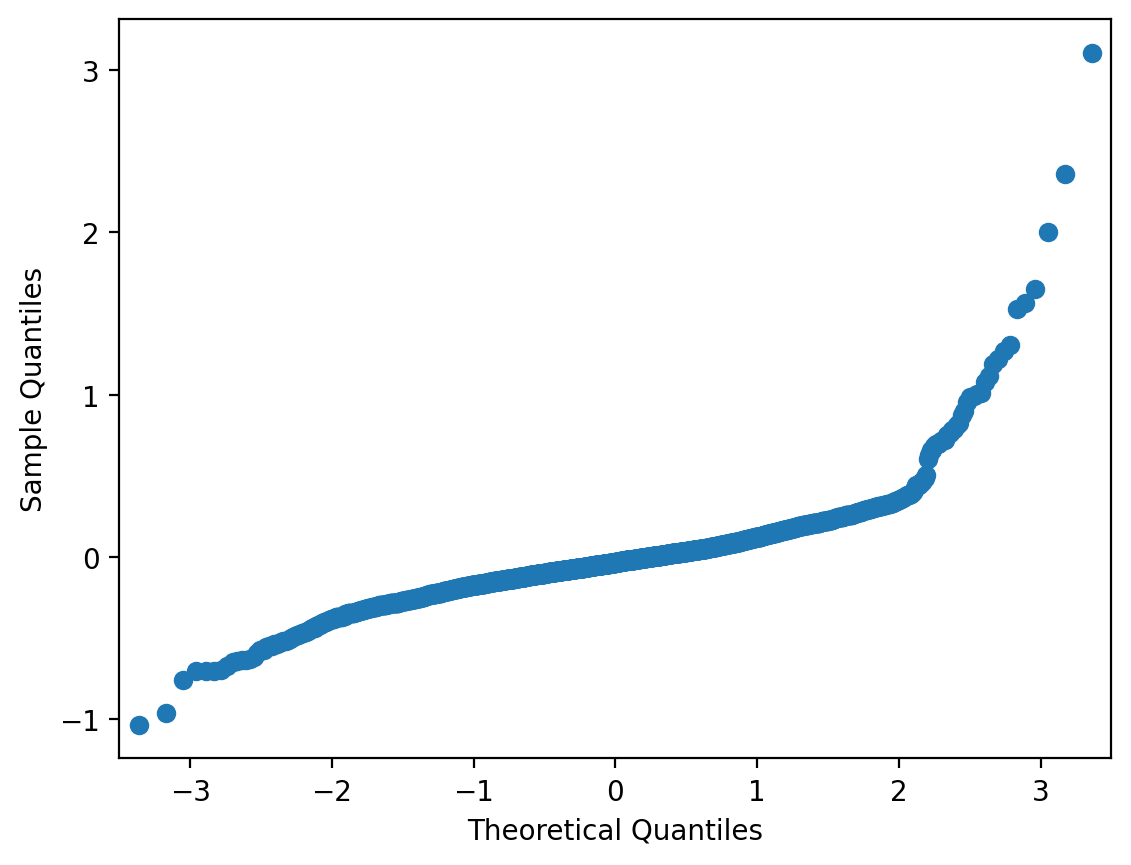

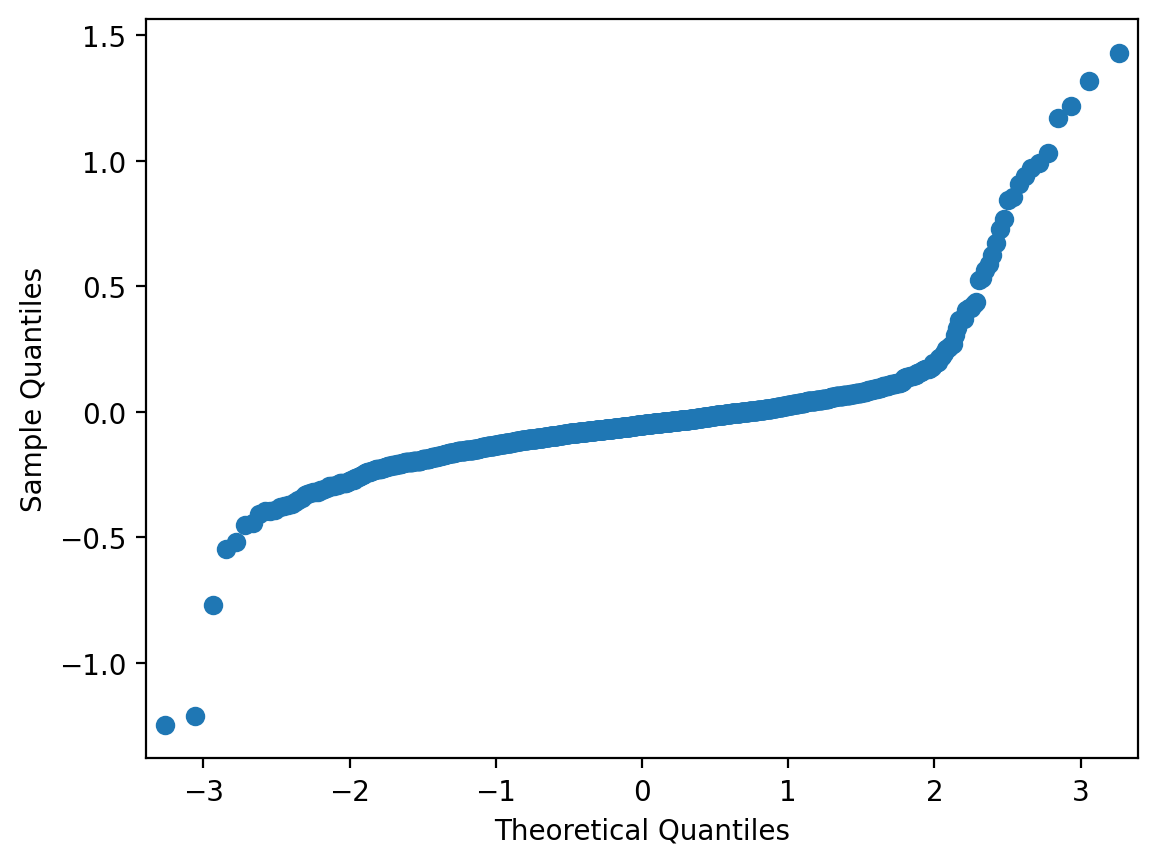

In [387]:
## Residual QQ plots

api.qqplot(resid_lmc_f, norm, fmt='.',color='paleturquoise');
api.qqplot(resid_lmc_1, norm, color='lightblue');
api.qqplot(resid_smc_f, norm, color='plum');
api.qqplot(resid_lmc_f, norm, color='pink');

### These do not look like normal distributions.   The LMC values seem somewhat normal, though they are very strongly peaked at zero.  The SMC values have a long positive tail.  This may be because it is such a tight and well-studied relation, which is why we can use these objects as standard candles.  It may also be because Cepheids are very bright, so their qualities can be measured with a lot of certainty.  We also were not given errors on the Wesenheit scores for these objects, so their distribution may be more normal when the error is taken into account.

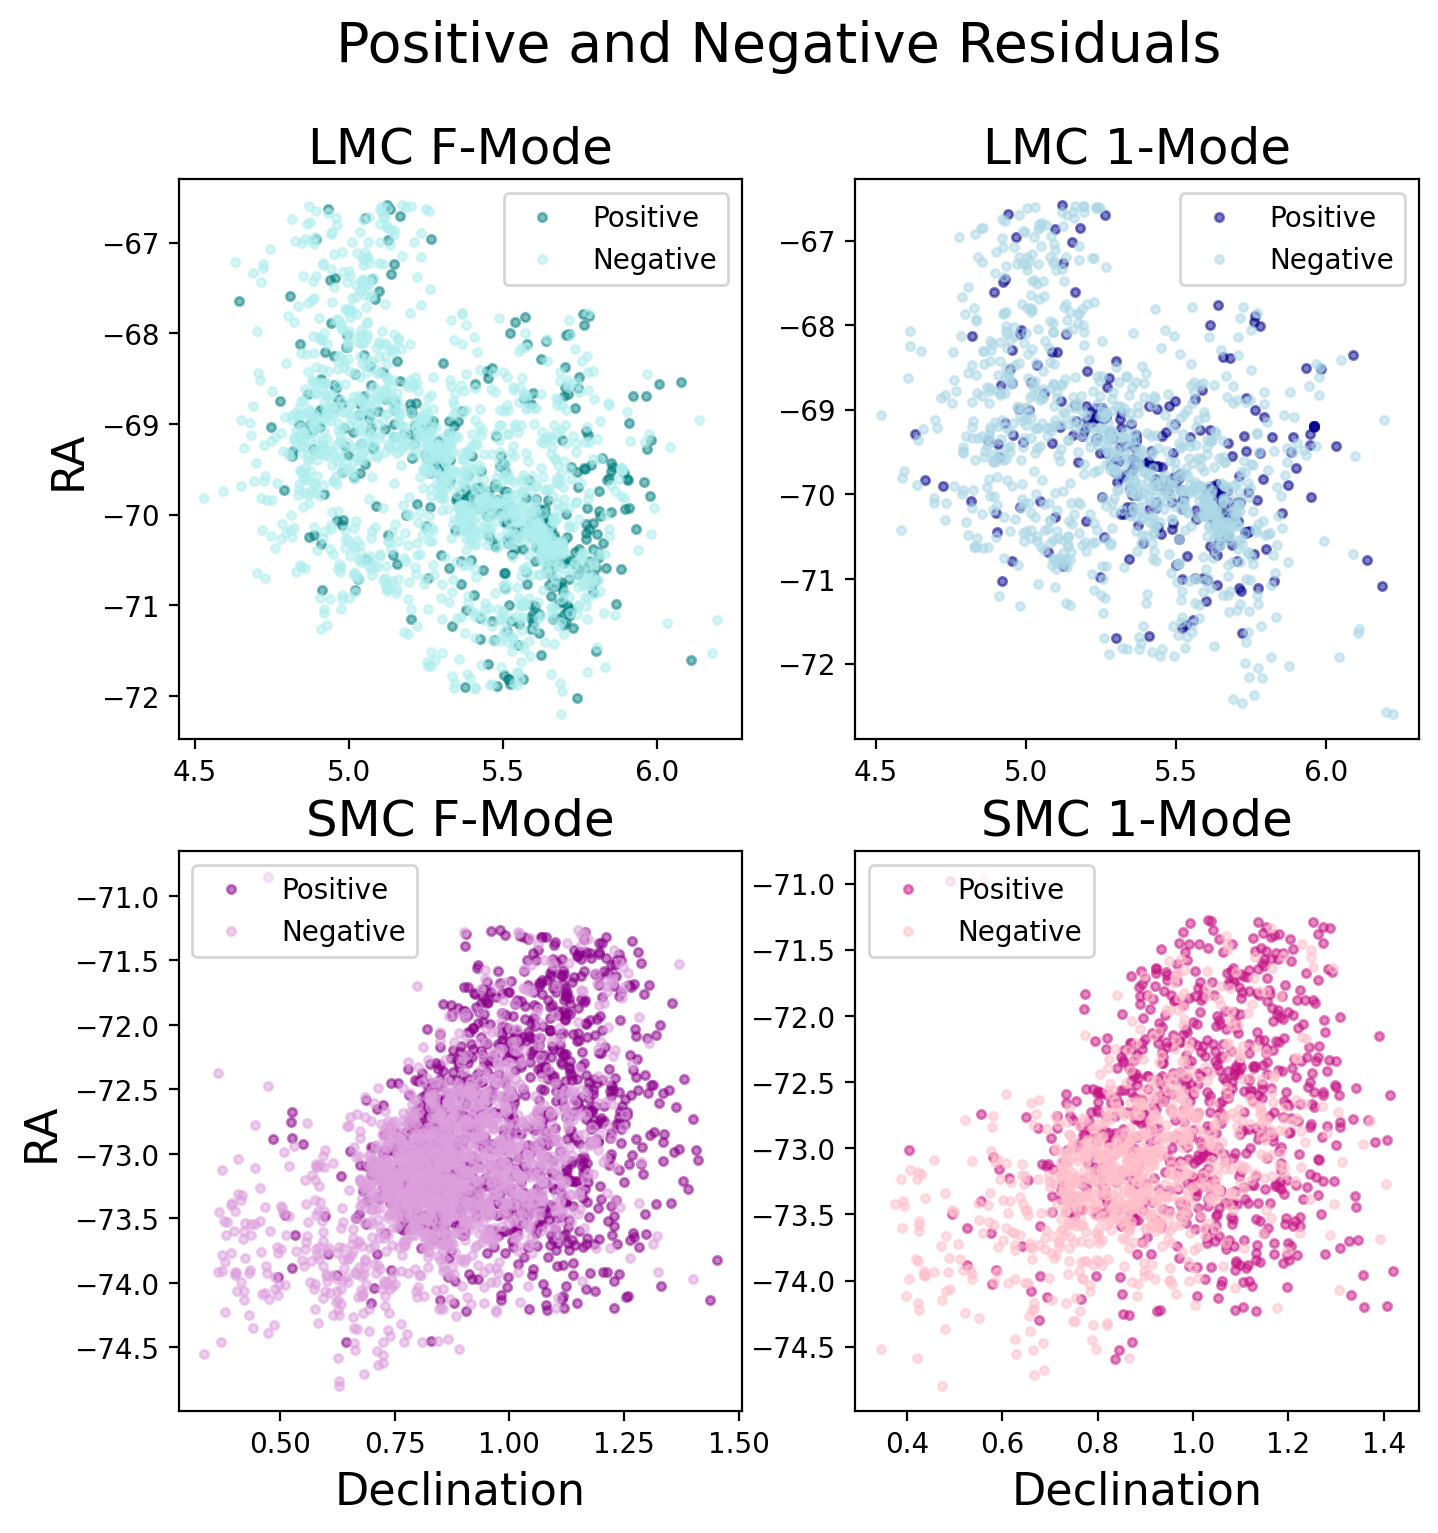

In [439]:
## Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1).


## Add residuals to cepheids dataframe
cepheids['resid'] = pd.concat((resid_lmc_f,resid_lmc_1,resid_smc_f,resid_smc_1),join='outer')

## Plot
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2,figsize=(8,8))
fig.suptitle('Positive and Negative Residuals',fontsize=20)

ax0.plot(cepheids.RA0[cepheids.Cloud=='LMC'][cepheids.Mode=='F'][cepheids.resid>0],
         cepheids.Decl0[cepheids.Cloud=='LMC'][cepheids.Mode=='F'][cepheids.resid>0],'.',color='teal',alpha=0.5,label='Positive')
ax0.plot(cepheids.RA0[cepheids.Cloud=='LMC'][cepheids.Mode=='F'][cepheids.resid<0],
         cepheids.Decl0[cepheids.Cloud=='LMC'][cepheids.Mode=='F'][cepheids.resid<0],'.',color='paleturquoise',alpha=0.5,label='Negative')
ax0.legend()
ax0.set_title('LMC F-Mode',fontsize=18)
ax0.set_ylabel('RA',fontsize=16)

ax1.plot(cepheids.RA0[cepheids.Cloud=='LMC'][cepheids.Mode=='1'][cepheids.resid>0],
         cepheids.Decl0[cepheids.Cloud=='LMC'][cepheids.Mode=='1'][cepheids.resid>0],'.',color='darkblue',alpha=0.5,label='Positive')
ax1.plot(cepheids.RA0[cepheids.Cloud=='LMC'][cepheids.Mode=='1'][cepheids.resid<0],
         cepheids.Decl0[cepheids.Cloud=='LMC'][cepheids.Mode=='1'][cepheids.resid<0],'.',color='lightblue',alpha=0.5,label='Negative')
ax1.legend()
ax1.set_title('LMC 1-Mode',fontsize=18)

ax2.plot(cepheids.RA0[cepheids.Cloud=='SMC'][cepheids.Mode=='F'][cepheids.resid>0],
         cepheids.Decl0[cepheids.Cloud=='SMC'][cepheids.Mode=='F'][cepheids.resid>0],'.',color='darkmagenta',alpha=0.5,label='Positive')
ax2.plot(cepheids.RA0[cepheids.Cloud=='SMC'][cepheids.Mode=='F'][cepheids.resid<0],
         cepheids.Decl0[cepheids.Cloud=='SMC'][cepheids.Mode=='F'][cepheids.resid<0],'.',color='plum',alpha=0.5,label='Negative')
ax2.legend()
ax2.set_title('SMC F-Mode',fontsize=18)
ax2.set_ylabel('RA',fontsize=16)
ax2.set_xlabel('Declination',fontsize=16)

ax3.plot(cepheids.RA0[cepheids.Cloud=='SMC'][cepheids.Mode=='1'][cepheids.resid>0],
         cepheids.Decl0[cepheids.Cloud=='SMC'][cepheids.Mode=='1'][cepheids.resid>0],'.',color='mediumvioletred',alpha=0.5,label='Positive')
ax3.plot(cepheids.RA0[cepheids.Cloud=='SMC'][cepheids.Mode=='1'][cepheids.resid<0],
         cepheids.Decl0[cepheids.Cloud=='SMC'][cepheids.Mode=='1'][cepheids.resid<0],'.',color='pink',alpha=0.5,label='Negative')
ax3.legend()
ax3.set_title('SMC 1-Mode',fontsize=18)
ax3.set_xlabel('Declination',fontsize=16);

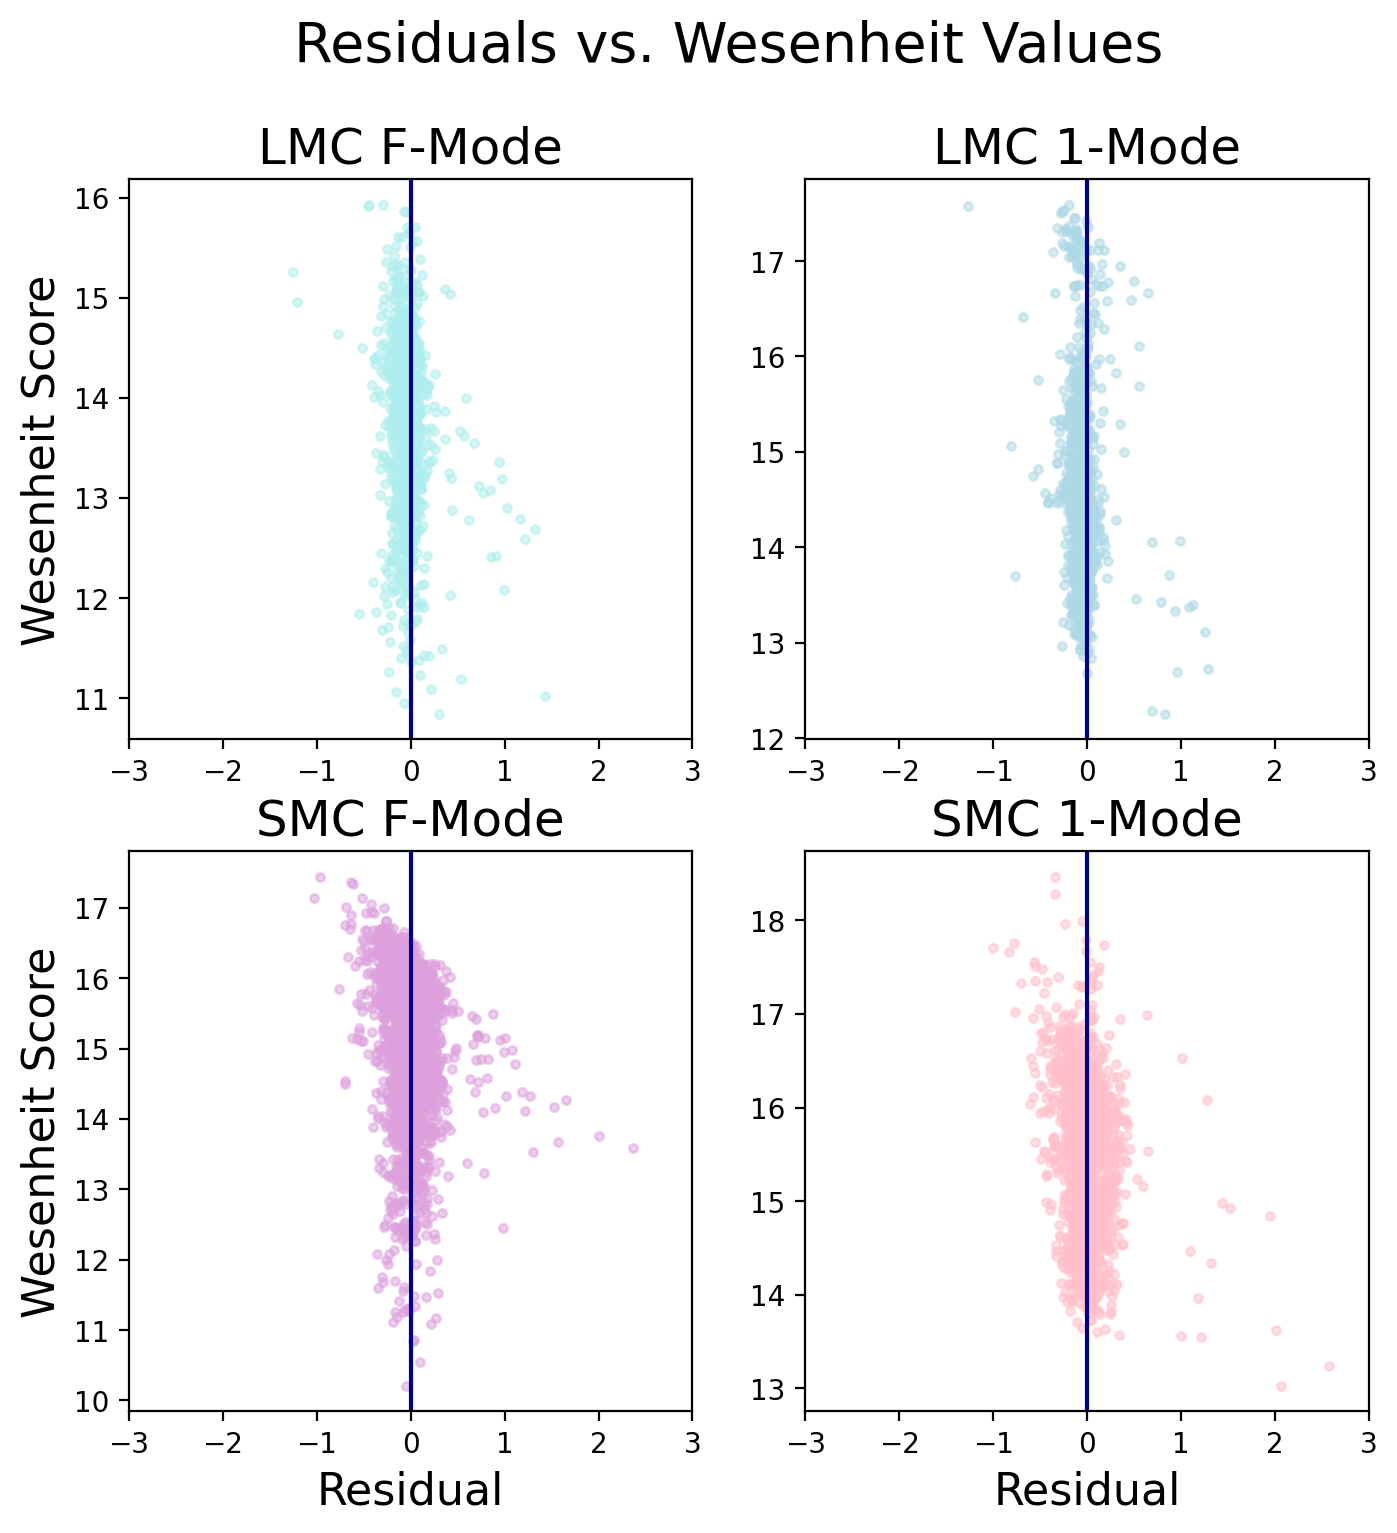

In [437]:
##Finally, plot the residuals against the fitted W values, and just to anticipate the next homework assignment, 

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2,figsize=(8,8))
fig.suptitle('Residuals vs. Wesenheit Values',fontsize=20)

ax0.plot(cepheids.resid[cepheids.Cloud=='LMC'][cepheids.Mode=='F'],
         cepheids.W[cepheids.Cloud=='LMC'][cepheids.Mode=='F'],'.',color='paleturquoise',alpha=0.5)
ax0.set_title('LMC F-Mode',fontsize=18)
ax0.axvline(0,color='darkblue')
ax0.set_ylabel('Wesenheit Score',fontsize=16)
ax0.set_xlim(-3,3)


ax1.plot(cepheids.resid[cepheids.Cloud=='LMC'][cepheids.Mode=='1'],
         cepheids.W[cepheids.Cloud=='LMC'][cepheids.Mode=='1'],'.',color='lightblue',alpha=0.5)
ax1.set_title('LMC 1-Mode',fontsize=18)
ax1.axvline(0,color='darkblue')
ax1.set_xlim(-3,3)


ax2.plot(cepheids.resid[cepheids.Cloud=='SMC'][cepheids.Mode=='F'],
         cepheids.W[cepheids.Cloud=='SMC'][cepheids.Mode=='F'],'.',color='plum',alpha=0.5)
ax2.set_title('SMC F-Mode',fontsize=18)
ax2.set_ylabel('Wesenheit Score',fontsize=16)
ax2.set_xlabel('Residual',fontsize=16)
ax2.axvline(0,color='darkblue')
ax2.set_xlim(-3,3)


ax3.plot(cepheids.resid[cepheids.Cloud=='SMC'][cepheids.Mode=='1'],
         cepheids.W[cepheids.Cloud=='SMC'][cepheids.Mode=='1'],'.',color='pink',alpha=0.5)
ax3.set_title('SMC 1-Mode',fontsize=18)
ax3.set_xlabel('Residual',fontsize=16)
ax3.axvline(0,color='darkblue')
ax3.set_xlim(-3,3);

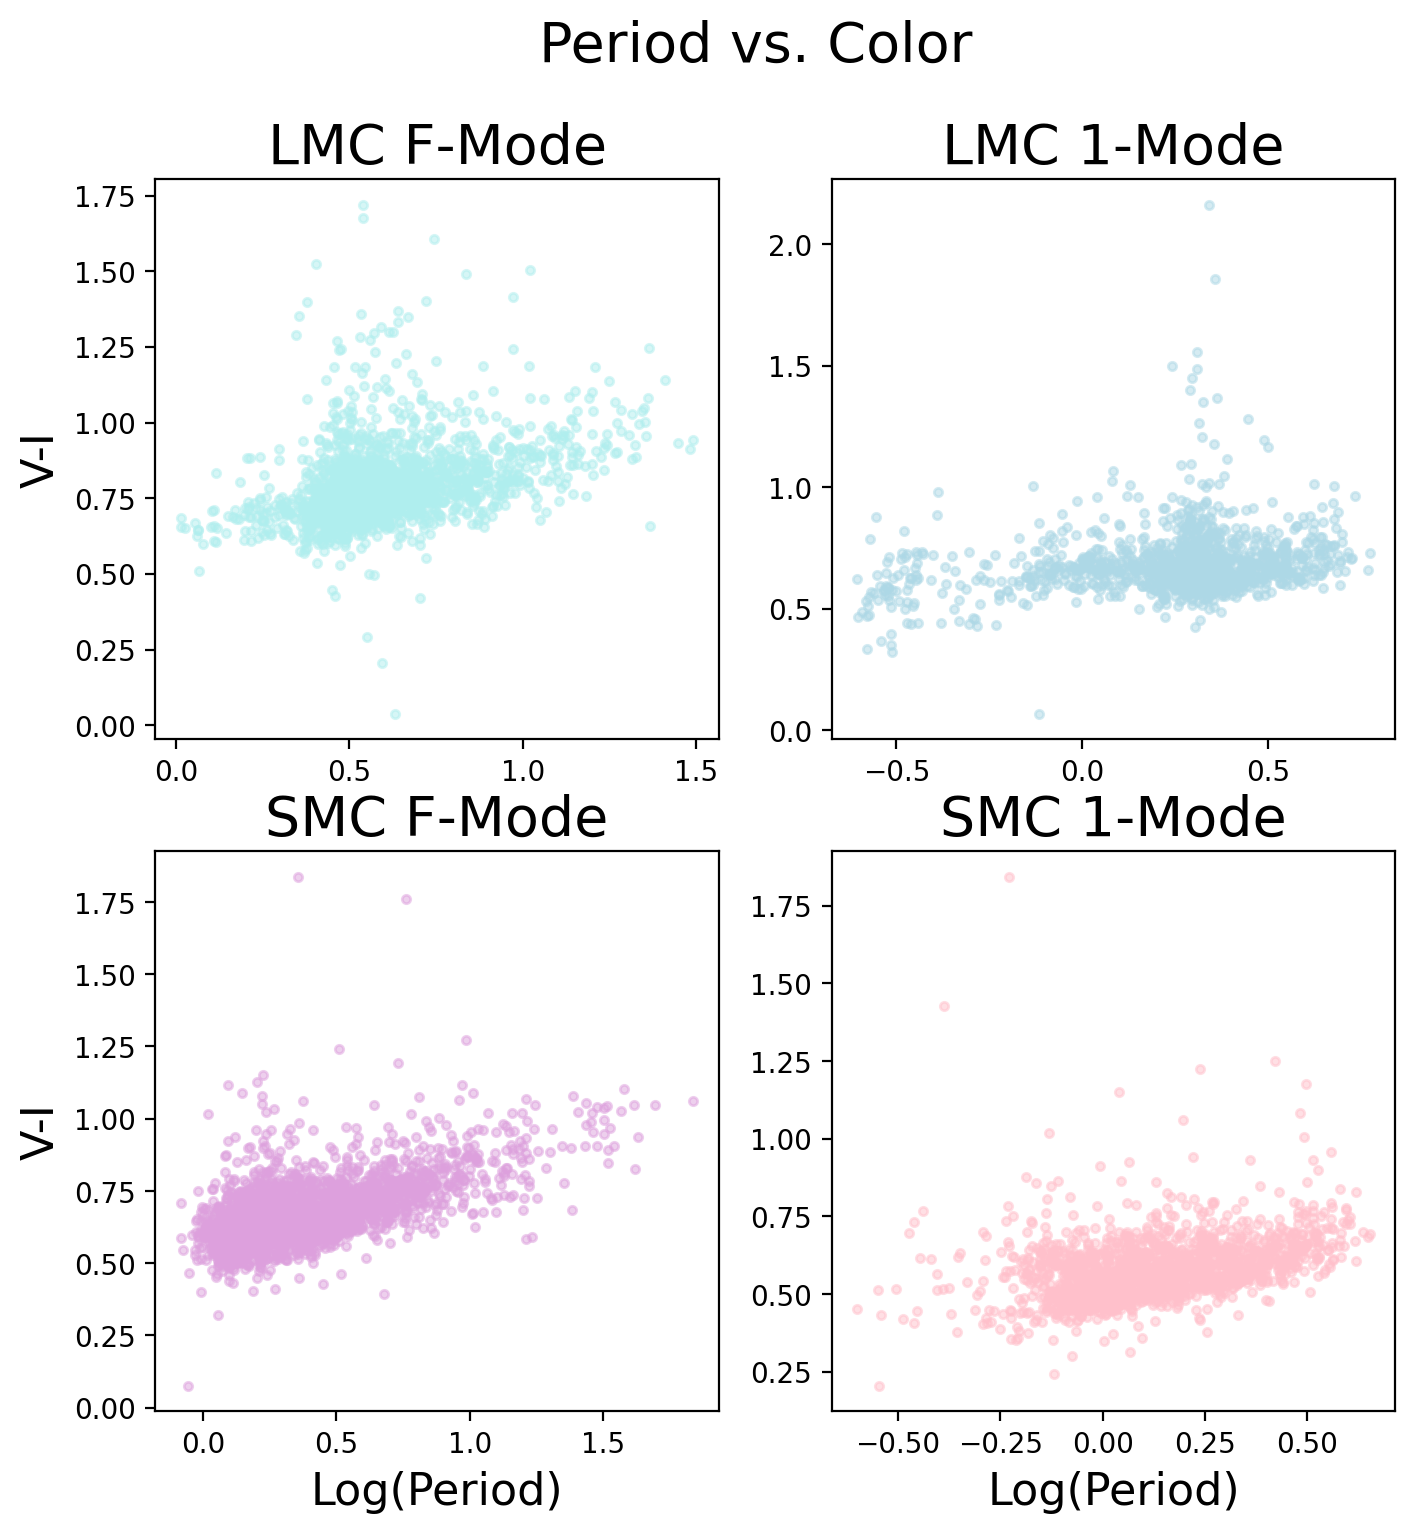

In [435]:
##also plot log(P1) vs V-I. Comment on what you are seeing.

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2,figsize=(8,8))
fig.suptitle('Period vs. Color',fontsize=20)

ax0.plot(cepheids.logP1[cepheids.Cloud=='LMC'][cepheids.Mode=='F'],
         cepheids.VI[cepheids.Cloud=='LMC'][cepheids.Mode=='F'],'.',color='paleturquoise',alpha=0.5)
ax0.set_title('LMC F-Mode',fontsize=20)
ax0.set_ylabel('V-I',fontsize=16)


ax1.plot(cepheids.logP1[cepheids.Cloud=='LMC'][cepheids.Mode=='1'],
         cepheids.VI[cepheids.Cloud=='LMC'][cepheids.Mode=='1'],'.',color='lightblue',alpha=0.5)
ax1.set_title('LMC 1-Mode',fontsize=20)


ax2.plot(cepheids.logP1[cepheids.Cloud=='SMC'][cepheids.Mode=='F'],
         cepheids.VI[cepheids.Cloud=='SMC'][cepheids.Mode=='F'],'.',color='plum',alpha=0.5)
ax2.set_title('SMC F-Mode',fontsize=20)
ax2.set_ylabel('V-I',fontsize=16)
ax2.set_xlabel('Log(Period)',fontsize=16)

ax3.plot(cepheids.logP1[cepheids.Cloud=='SMC'][cepheids.Mode=='1'],
         cepheids.VI[cepheids.Cloud=='SMC'][cepheids.Mode=='1'],'.',color='pink',alpha=0.5)
ax3.set_title('SMC 1-Mode',fontsize=20)
ax3.set_xlabel('Log(Period)',fontsize=16);

### V-I color increases slightly with period, but not much.  There is a lot of scatter/a lot of outliers above most of the points in V-I space, but not below.  Wesenheit scores also tend to be above the relation rather than below it.  This may be because it is easier to detect brighter Cepheid variables than dimmer ones, or perhaps because brighter variables are saturating the detector and their period is being underestimated.  It also appears that the SMC has an uneven distribution of positive and negative residuals across its extent; perhaps the brighter side is closer to us than the negative side?  The LMC is evenly distributed and may be face-on relative to us.